# Import Libraries

In [7]:
%pip install pytorch_msssim

In [8]:
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from pytorch_msssim import ssim

# Define hyperparameters

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Training classifier params
CLS_EPOCHS = 50
CLS_BATCH = 128
CLS_LR = 0.1

# Generator / inversion params
GEN_EPOCHS = 100
GEN_BATCH = 64
latent_dim = 100
cond_dim = 10
F_ch = 64                 # channels at 10x10 stage
alpha, beta, gamma, delta = 100.0, 100.0, 1000.0, 1000.0

# Other
NUM_CLASSES = 10
SAMPLES_PER_CLASS = 20    # for evaluation
SAVE_MODEL_PATH = "resnet_cifar10.pth"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Device: cuda


# Data loaders

In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # scale to [-1,1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=CLS_BATCH, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 47.7MB/s]


In [11]:
len(trainloader)

391

# Classifier (ResNet18)

In [12]:
class ResNetCIFAR(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()

        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  # remove downsampling

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x, return_features=False):
        # Replicate torchvision forward manually to access penultimate features
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        feat = torch.flatten(x, 1)
        logits = self.resnet.fc(feat)

        if return_features:
            return logits, feat
        return logits


# Instantiate
classifier = ResNetCIFAR(num_classes=NUM_CLASSES).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


# Classifier training utilities


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer_cls = optim.SGD(classifier.parameters(), lr=CLS_LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_cls, milestones=[60, 120, 160], gamma=0.2)

def train_classifier_one_epoch(epoch):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    start = time.time()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item() * targets.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / total
    train_acc = 100. * correct / total
    print(f"[CLS] Epoch {epoch} Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% Time: {time.time()-start:.1f}s")
    return train_loss, train_acc

def test_classifier(epoch):
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = classifier(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * targets.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_loss = running_loss / total
    acc = 100. * correct / total
    print(f"[CLS] Epoch {epoch} Test Loss: {test_loss:.4f} Acc: {acc:.2f}%")
    return test_loss, acc

# Train classifier


Training classifier from scratch...
[CLS] Epoch 1 Train Loss: 2.6778 Acc: 21.07% Time: 43.7s
[CLS] Epoch 1 Test Loss: 1.9963 Acc: 30.48%
[CLS] Saved best model (acc=30.48%)
[CLS] Epoch 2 Train Loss: 1.6966 Acc: 36.36% Time: 40.2s
[CLS] Epoch 2 Test Loss: 1.5458 Acc: 42.34%
[CLS] Saved best model (acc=42.34%)
[CLS] Epoch 3 Train Loss: 1.4756 Acc: 45.70% Time: 41.8s
[CLS] Epoch 3 Test Loss: 1.3526 Acc: 50.79%
[CLS] Saved best model (acc=50.79%)
[CLS] Epoch 4 Train Loss: 1.2946 Acc: 53.46% Time: 40.9s
[CLS] Epoch 4 Test Loss: 1.2965 Acc: 53.92%
[CLS] Saved best model (acc=53.92%)
[CLS] Epoch 5 Train Loss: 1.1356 Acc: 59.40% Time: 41.3s
[CLS] Epoch 5 Test Loss: 1.1030 Acc: 60.96%
[CLS] Saved best model (acc=60.96%)
[CLS] Epoch 6 Train Loss: 0.9963 Acc: 64.62% Time: 41.2s
[CLS] Epoch 6 Test Loss: 0.9978 Acc: 65.02%
[CLS] Saved best model (acc=65.02%)
[CLS] Epoch 7 Train Loss: 0.8921 Acc: 68.62% Time: 41.1s
[CLS] Epoch 7 Test Loss: 0.8855 Acc: 69.14%
[CLS] Saved best model (acc=69.14%)
[CLS]

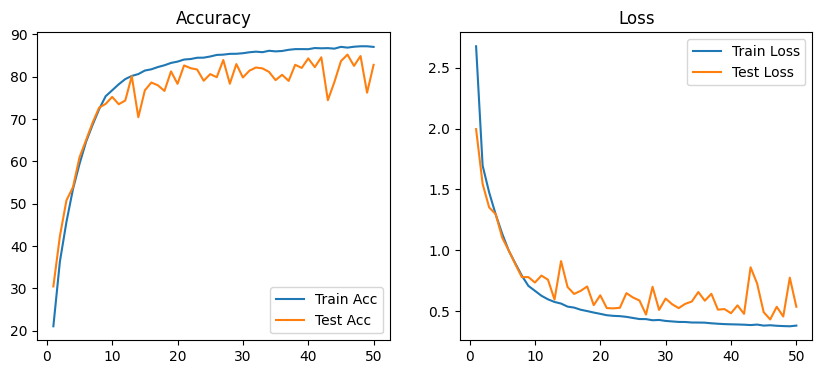

ResNetCIFAR(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [14]:
def train_classifier(epochs=CLS_EPOCHS):
    best_acc = 0.0
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_classifier_one_epoch(ep)
        te_loss, te_acc = test_classifier(ep)
        scheduler.step()
        train_losses.append(tr_loss); train_accs.append(tr_acc)
        test_losses.append(te_loss); test_accs.append(te_acc)
        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(classifier.state_dict(), SAVE_MODEL_PATH)
            print(f"[CLS] Saved best model (acc={best_acc:.2f}%)")
    # plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc')
    plt.plot(range(1,len(test_accs)+1), test_accs, label='Test Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1,len(test_losses)+1), test_losses, label='Test Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

# Only train classifier if model file not present
if not os.path.isfile(SAVE_MODEL_PATH):
    print("Training classifier from scratch...")
    train_classifier(epochs=CLS_EPOCHS)
else:
    print("Found saved classifier. Loading...")
    classifier.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device))

# Freeze classifier (but allow autograd to flow into generator through the classifier's ops)
for p in classifier.parameters():
    p.requires_grad = False
classifier.eval()

# Conditioning utils & precompute hot matrices


In [15]:
# We will pass the **softmaxed** conditioning vector INTO the generator (so it's a distribution).
def sample_vector_condition(batch, num_classes, device):
    v = torch.randn(batch, num_classes, device=device)
    P = F.softmax(v, dim=1)      # conditioning distribution P (batch, num_classes)
    labels = P.argmax(dim=1)     # integer labels used in CE target
    return P, P, labels         # return vector_cond (P), P_target, labels

# Precompute 'hot' matrices for all classes and reuse
_precomputed_hot = torch.zeros(NUM_CLASSES, 1, NUM_CLASSES, NUM_CLASSES, device=device)
for k in range(NUM_CLASSES):
    mat = torch.zeros(NUM_CLASSES, NUM_CLASSES, device=device)
    mat[k, :] = 1.0
    mat[:, k] = 1.0
    _precomputed_hot[k, 0] = mat

def build_hot_matrix(labels, N=NUM_CLASSES, device=device):
    # labels: (batch,) ints on device
    # returns (batch,1,10,10) by creating appropriate matrices
    batch_size = labels.size(0)
    hot_mats = torch.zeros(batch_size, 1, 10, 10, device=device)

    for i, label in enumerate(labels):
        # Create a 10x10 matrix with the label information
        # You can experiment with different patterns here
        mat = torch.zeros(10, 10, device=device)

        # Simple pattern: set rows and columns corresponding to label
        mat[label, :] = 1.0
        mat[:, label] = 1.0

        hot_mats[i, 0] = mat

    return hot_mats

# Generator



In [16]:
# Fix the generator architecture first
class Generator(nn.Module):
    def __init__(self, latent_dim=latent_dim, cond_dim=cond_dim, F=F_ch, out_ch=3):
        super().__init__()
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim

        # Initial projection to 4x4
        self.convT1 = nn.ConvTranspose2d(latent_dim + cond_dim, F * 8, kernel_size=4, stride=1, padding=0)  # 1x1 -> 4x4
        self.bn1 = nn.BatchNorm2d(F * 8)

        # 4x4 -> 8x8
        self.convT2 = nn.ConvTranspose2d(F * 8 + 1, F * 4, kernel_size=4, stride=2, padding=1)  # +1 for hot channel
        self.bn2 = nn.BatchNorm2d(F * 4)

        # 8x8 -> 16x16
        self.convT3 = nn.ConvTranspose2d(F * 4, F * 2, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(F * 2)

        # 16x16 -> 32x32
        self.convT4 = nn.ConvTranspose2d(F * 2, F, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(F)

        # Final convolution to get 3 channels
        self.final_conv = nn.Conv2d(F, out_ch, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(0.2)  # Reduced dropout

    def forward(self, z, vec_cond, hot_mat):
        # z: (B, latent), vec_cond: (B, cond_dim), hot_mat: (B,1,10,10)
        x = torch.cat([z, vec_cond], dim=1)           # (B, latent+cond)
        x = x.view(x.size(0), x.size(1), 1, 1)        # (B, latent+cond,1,1)

        # 1x1 -> 4x4
        x = F.leaky_relu(self.bn1(self.convT1(x)), 0.2)

        # Resize hot_mat to match current feature size (4x4)
        hot_resized = F.interpolate(hot_mat, size=(4, 4), mode='bilinear', align_corners=False)
        x = torch.cat([x, hot_resized], dim=1)

        # 4x4 -> 8x8
        x = F.leaky_relu(self.bn2(self.convT2(x)), 0.2)
        x = self.dropout(x)

        # 8x8 -> 16x16
        x = F.leaky_relu(self.bn3(self.convT3(x)), 0.2)

        # 16x16 -> 32x32
        x = F.leaky_relu(self.bn4(self.convT4(x)), 0.2)

        img = torch.tanh(self.final_conv(x))  # range [-1,1]
        return img

# Loss utilities

In [17]:
def kl_divergence_targetP(logits, P_target):
    # D_KL(P_target || Q_pred)
    # logits: (B,C); P_target: (B,C)
    log_softmax = F.log_softmax(logits, dim=1)
    kl_div = F.kl_div(log_softmax, P_target, reduction='batchmean', log_target=False)
    return kl_div

def cosine_similarity_loss(features):
    # features: (B, D)
    eps = 1e-8
    f = features / (features.norm(dim=1, keepdim=True) + eps)  # normalize
    sim = f @ f.T  # (B,B)
    B = features.size(0)
    off_diag_sum = sim.sum() - B  # subtract diagonal ones
    denom = B * (B - 1)
    return off_diag_sum / (denom + 1e-12)

def orthogonality_loss(features):
    # make normalized features orthogonal (Gram approx I)
    eps = 1e-8
    f = features / (features.norm(dim=1, keepdim=True) + eps)
    G = f @ f.T
    B = features.size(0)
    I = torch.eye(B, device=features.device)
    return ((G - I)**2).mean()
def ssim_loss(imgs, ref_imgs):
    """
    Structural Similarity (SSIM) loss between generated and reference images.
    Both tensors in range [-1, 1].
    Returns (1 - SSIM) averaged over the batch.
    """
    return 1 - ssim(imgs, ref_imgs, data_range=2.0, size_average=True)
# Improved loss function with better balancing
def compute_inversion_loss(
    logits, features, P_target, labels,
    imgs=None, ref_imgs=None,
    alpha=1.0, beta=1.0, gamma=0.01, delta=0.01, eta=0.5
):
    """
    Total inversion loss = α * KL + β * CE + γ * CosSim + δ * Orthogonality + η * (1 - SSIM)
    """

    # Core inversion losses
    L_kl = kl_divergence_targetP(logits, P_target)
    L_ce = F.cross_entropy(logits, labels)
    L_cos = cosine_similarity_loss(features)
    L_ortho = orthogonality_loss(features)

    # SSIM Loss (optional, requires reference images)
    if imgs is not None and ref_imgs is not None:
        L_ssim = ssim_loss(imgs, ref_imgs)
    else:
        L_ssim = torch.tensor(0.0, device=logits.device)

    total_loss = (
        alpha * L_kl +
        beta * L_ce +
        gamma * L_cos +
        delta * L_ortho +
        eta * L_ssim
    )

    return {
        "L_kl": L_kl,
        "L_ce": L_ce,
        "L_cos": L_cos,
        "L_ortho": L_ortho,
        "L_ssim": L_ssim,
        "total": total_loss
    }



# Inversion training


In [18]:
alpha, beta, gamma, delta, eta = 100.0, 200.0, 1000.0, 1000.0, 1000.0  # tuned weights
gen = Generator().to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))

def train_generator(epochs=GEN_EPOCHS, batch_size=GEN_BATCH):
    gen.train()

    for ep in range(1, epochs + 1):
        epoch_loss = epoch_Lkl = epoch_Lce = epoch_Lcos = epoch_Lortho = epoch_Lssim = 0.0
        t0 = time.time()
        steps = len(trainloader)

        for step in range(steps):
            # Sample conditioning
            vec_cond, P_target, labels = sample_vector_condition(batch_size, NUM_CLASSES, device)
            z = torch.randn(batch_size, latent_dim, device=device)
            hot = build_hot_matrix(labels, N=NUM_CLASSES, device=device)

            # Generate images
            imgs = gen(z, vec_cond, hot)

            # Create structural reference (slightly perturbed copy)
            ref_imgs = imgs + 0.02 * torch.randn_like(imgs)

            # Forward through frozen classifier
            logits, features = classifier(imgs, return_features=True)

            # Compute combined inversion + SSIM loss
            loss_dict = compute_inversion_loss(
                logits, features, P_target, labels,
                imgs=imgs, ref_imgs=ref_imgs,
                alpha=alpha, beta=beta, gamma=gamma, delta=delta, eta=eta
            )

            total_loss = loss_dict["total"] # Rename the variable to avoid conflict

            gen_opt.zero_grad()
            total_loss.backward() # Use the renamed variable
            torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
            gen_opt.step()

            # Accumulate stats
            epoch_loss += total_loss.item()
            epoch_Lkl += loss_dict["L_kl"].item()
            epoch_Lce += loss_dict["L_ce"].item()
            epoch_Lcos += loss_dict["L_cos"].item()
            epoch_Lortho += loss_dict["L_ortho"].item()
            epoch_Lssim += loss_dict["L_ssim"].item()


        # Epoch summary
        steps = float(steps)
        print(f"[GEN] Ep {ep}/{epochs} | Loss {epoch_loss/steps:.4f} | "
              f"KL {epoch_Lkl/steps:.4f} | CE {epoch_Lce/steps:.4f} | "
              f"COS {epoch_Lcos/steps:.4f} | ORT {epoch_Lortho/steps:.4f} | "
              f"SSIM {epoch_Lssim/steps:.4f} | time {time.time()-t0:.1f}s")

        # Evaluate & visualize every few epochs
        if ep % 10 == 0:
            acc = inversion_accuracy(gen, classifier)
            print(f"[GEN] Inversion Accuracy: {acc:.2f}%")
            show_generated_images(gen, classifier, samples_per_class=4)
            torch.save(gen.state_dict(), f"gen_epoch{ep}.pth")

# Evaluation


In [19]:
def inversion_accuracy(
    gen,
    classifier,
    num_classes=NUM_CLASSES,
    n_per_class=100,
    latent_dim=latent_dim,
    batch_size=32
):
    """
    Inversion Accuracy refers to the percentage of images generated with desired labels same as the output labels from the classifier.
    """
    gen.eval()
    classifier.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for cls in range(num_classes):
            for start in range(0, n_per_class, batch_size):
                bsz = min(batch_size, n_per_class - start)
                z = torch.randn(bsz, latent_dim, device=device)
                c = torch.zeros(bsz, num_classes, device=device)
                c[:, cls] = 1.0
                hot = build_hot_matrix(torch.full((bsz,), cls, device=device), N=num_classes, device=device)

                imgs = gen(z, c, hot)
                logits, _ = classifier(imgs, return_features=True)
                preds = logits.argmax(dim=1)

                correct += (preds == cls).sum().item()
                total += bsz

    return 100.0 * correct / total


def show_generated_images(
    gen,
    classifier,
    latent_dim=latent_dim,
    num_classes=NUM_CLASSES,
    samples_per_class=8
):
    gen.eval()
    classifier.eval()

    with torch.no_grad():
        fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class, num_classes))

        for cls in range(num_classes):
            # 1. Sample Latent + Conditioning
            z = torch.randn(samples_per_class, latent_dim, device=device)
            c = torch.zeros(samples_per_class, num_classes, device=device)
            c[:, cls] = 1.0  # one-hot class conditioning
            hot = build_hot_matrix(torch.full((samples_per_class,), cls, device=device),
                                   N=num_classes, device=device)

            # 2. Generate Images
            imgs = gen(z, c, hot)

            # 3. Classifier Prediction (batch-based → efficient)
            logits, _ = classifier(imgs, return_features=True)
            preds = logits.argmax(dim=1)

            # 4. Convert to displayable format
            imgs = (imgs + 1.0) / 2.0
            imgs = imgs.clamp(0, 1)

            for i in range(samples_per_class):
                ax = axes[cls, i] if num_classes > 1 else axes[i]
                img = imgs[i].cpu().permute(1, 2, 0).numpy()

                ax.imshow(img)
                ax.axis("off")

                true_label = cls
                pred_label = preds[i].item()
                color = "green" if true_label == pred_label else "red"

                ax.set_title(f"T:{true_label} | P:{pred_label}", fontsize=8, color=color)

        plt.tight_layout()
        plt.show()


def eval_tsne_grid(
    gen,
    classifier,
    samples_per_class=100,
    num_classes=NUM_CLASSES,
    latent_dim=latent_dim,
    seed=42
):
    gen.eval()
    classifier.eval()
    all_features, all_labels, all_preds = [], [], []

    torch.manual_seed(seed)
    np.random.seed(seed)

    with torch.no_grad():
        for label in range(num_classes):
            labels = torch.full((samples_per_class,), label, dtype=torch.long, device=device)
            v_raw = F.softmax(torch.randn(samples_per_class, num_classes, device=device), dim=1)
            hot_mat = build_hot_matrix(labels, N=num_classes, device=device)
            z = torch.randn(samples_per_class, latent_dim, device=device)

            imgs = gen(z, v_raw, hot_mat)
            logits, feats = classifier(imgs, return_features=True)
            preds = logits.argmax(dim=1)

            all_features.append(feats.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    # Concatenate
    all_features = torch.cat(all_features, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()

    acc = np.mean(all_labels == all_preds) * 100
    print(f"[t-SNE] Inversion Accuracy: {acc:.2f}%")

    # Dimensionality reduction
    pca = PCA(n_components=min(50, all_features.shape[1]))
    features_pca = pca.fit_transform(all_features)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=seed)
    features_2d = tsne.fit_transform(features_pca)
    plt.figure(figsize=(8, 6))
    for label in range(num_classes):
        idx = all_labels == label
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Class {label}", alpha=0.7, s=12)
    plt.legend()
    plt.title("t-SNE of Generator Feature Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

# Run generator training


Starting generator training...
[GEN] Ep 1/100 | Loss 1499.2407 | KL 0.9843 | CE 2.6937 | COS 0.5273 | ORT 0.3317 | SSIM 0.0031 | time 24.9s
[GEN] Ep 2/100 | Loss 946.8577 | KL 1.0787 | CE 0.9708 | COS 0.4216 | ORT 0.2218 | SSIM 0.0015 | time 24.1s
[GEN] Ep 3/100 | Loss 768.6785 | KL 1.3530 | CE 0.3648 | COS 0.3734 | ORT 0.1859 | SSIM 0.0011 | time 24.0s
[GEN] Ep 4/100 | Loss 703.5979 | KL 1.3703 | CE 0.2424 | COS 0.3480 | ORT 0.1690 | SSIM 0.0011 | time 24.0s
[GEN] Ep 5/100 | Loss 666.4083 | KL 1.3439 | CE 0.2037 | COS 0.3316 | ORT 0.1586 | SSIM 0.0010 | time 24.0s
[GEN] Ep 6/100 | Loss 641.3397 | KL 1.3043 | CE 0.1891 | COS 0.3202 | ORT 0.1519 | SSIM 0.0010 | time 24.1s
[GEN] Ep 7/100 | Loss 624.0475 | KL 1.2688 | CE 0.1823 | COS 0.3122 | ORT 0.1475 | SSIM 0.0010 | time 24.1s
[GEN] Ep 8/100 | Loss 611.1369 | KL 1.2431 | CE 0.1827 | COS 0.3058 | ORT 0.1434 | SSIM 0.0011 | time 24.1s
[GEN] Ep 9/100 | Loss 600.1341 | KL 1.2149 | CE 0.1838 | COS 0.3005 | ORT 0.1403 | SSIM 0.0011 | time 24

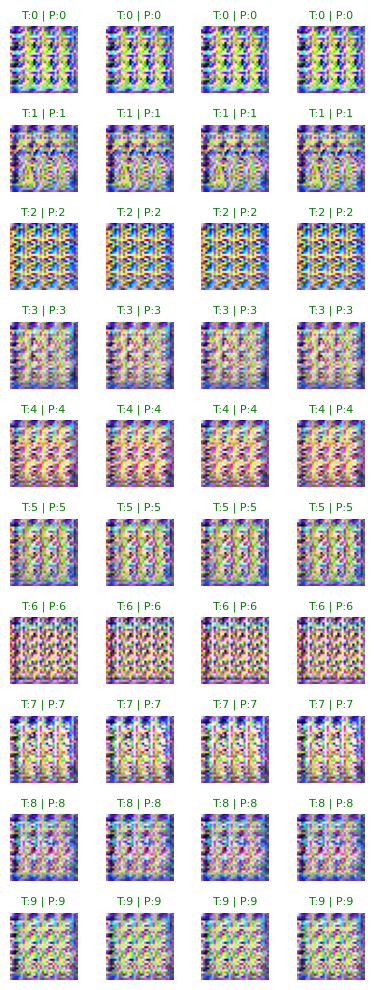

[GEN] Ep 11/100 | Loss 579.7932 | KL 1.1801 | CE 0.1824 | COS 0.2889 | ORT 0.1352 | SSIM 0.0011 | time 24.0s
[GEN] Ep 12/100 | Loss 570.7891 | KL 1.1655 | CE 0.1825 | COS 0.2838 | ORT 0.1328 | SSIM 0.0011 | time 24.0s
[GEN] Ep 13/100 | Loss 565.3904 | KL 1.1567 | CE 0.1864 | COS 0.2803 | ORT 0.1311 | SSIM 0.0011 | time 24.1s
[GEN] Ep 14/100 | Loss 558.7106 | KL 1.1405 | CE 0.1864 | COS 0.2768 | ORT 0.1295 | SSIM 0.0011 | time 24.0s
[GEN] Ep 15/100 | Loss 555.0641 | KL 1.1326 | CE 0.1886 | COS 0.2744 | ORT 0.1286 | SSIM 0.0011 | time 24.0s
[GEN] Ep 16/100 | Loss 550.7768 | KL 1.1226 | CE 0.1907 | COS 0.2721 | ORT 0.1272 | SSIM 0.0010 | time 24.0s
[GEN] Ep 17/100 | Loss 547.9773 | KL 1.1181 | CE 0.1921 | COS 0.2703 | ORT 0.1264 | SSIM 0.0010 | time 24.0s
[GEN] Ep 18/100 | Loss 543.3523 | KL 1.1089 | CE 0.1929 | COS 0.2678 | ORT 0.1251 | SSIM 0.0010 | time 24.0s
[GEN] Ep 19/100 | Loss 541.1246 | KL 1.0991 | CE 0.1955 | COS 0.2667 | ORT 0.1244 | SSIM 0.0010 | time 24.0s
[GEN] Ep 20/100 | L

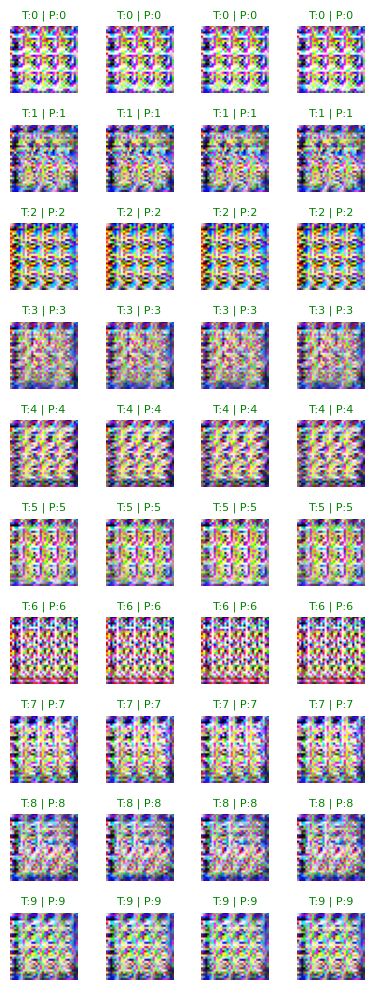

[GEN] Ep 21/100 | Loss 535.4650 | KL 1.0907 | CE 0.1970 | COS 0.2632 | ORT 0.1228 | SSIM 0.0010 | time 24.2s
[GEN] Ep 22/100 | Loss 532.3938 | KL 1.0881 | CE 0.1969 | COS 0.2616 | ORT 0.1216 | SSIM 0.0010 | time 24.2s
[GEN] Ep 23/100 | Loss 529.9688 | KL 1.0813 | CE 0.1980 | COS 0.2603 | ORT 0.1209 | SSIM 0.0010 | time 24.2s
[GEN] Ep 24/100 | Loss 528.9678 | KL 1.0757 | CE 0.2001 | COS 0.2597 | ORT 0.1207 | SSIM 0.0010 | time 24.2s
[GEN] Ep 25/100 | Loss 528.1497 | KL 1.0710 | CE 0.2002 | COS 0.2590 | ORT 0.1210 | SSIM 0.0010 | time 24.2s
[GEN] Ep 26/100 | Loss 525.8235 | KL 1.0671 | CE 0.2006 | COS 0.2579 | ORT 0.1201 | SSIM 0.0010 | time 24.2s
[GEN] Ep 27/100 | Loss 523.7022 | KL 1.0653 | CE 0.1999 | COS 0.2568 | ORT 0.1194 | SSIM 0.0010 | time 24.3s
[GEN] Ep 28/100 | Loss 522.5803 | KL 1.0596 | CE 0.2017 | COS 0.2561 | ORT 0.1192 | SSIM 0.0010 | time 24.2s
[GEN] Ep 29/100 | Loss 521.8284 | KL 1.0532 | CE 0.2001 | COS 0.2558 | ORT 0.1197 | SSIM 0.0010 | time 24.1s
[GEN] Ep 30/100 | L

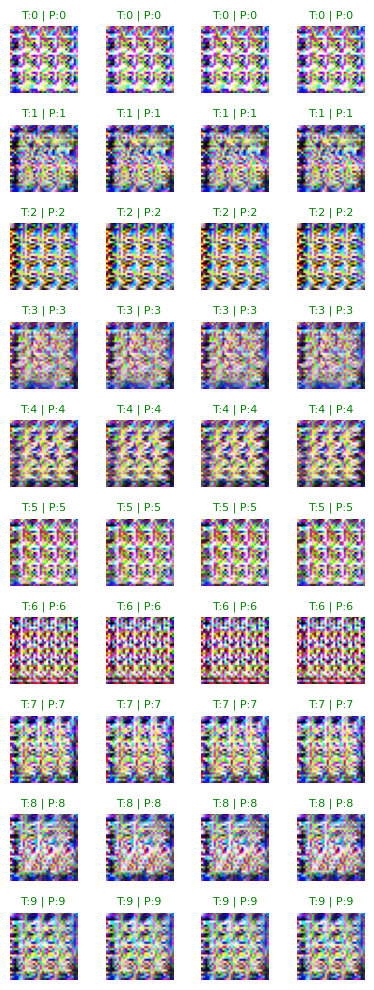

[GEN] Ep 31/100 | Loss 518.2278 | KL 1.0489 | CE 0.2040 | COS 0.2538 | ORT 0.1178 | SSIM 0.0010 | time 24.2s
[GEN] Ep 32/100 | Loss 519.3891 | KL 1.0473 | CE 0.2064 | COS 0.2541 | ORT 0.1184 | SSIM 0.0010 | time 24.1s
[GEN] Ep 33/100 | Loss 517.1039 | KL 1.0450 | CE 0.2047 | COS 0.2529 | ORT 0.1178 | SSIM 0.0010 | time 24.1s
[GEN] Ep 34/100 | Loss 515.1209 | KL 1.0413 | CE 0.2044 | COS 0.2520 | ORT 0.1171 | SSIM 0.0009 | time 28.1s
[GEN] Ep 35/100 | Loss 513.8993 | KL 1.0405 | CE 0.2053 | COS 0.2510 | ORT 0.1168 | SSIM 0.0009 | time 24.1s
[GEN] Ep 36/100 | Loss 512.7874 | KL 1.0390 | CE 0.2057 | COS 0.2505 | ORT 0.1163 | SSIM 0.0009 | time 24.1s
[GEN] Ep 37/100 | Loss 512.9598 | KL 1.0355 | CE 0.2048 | COS 0.2506 | ORT 0.1169 | SSIM 0.0009 | time 24.1s
[GEN] Ep 38/100 | Loss 511.7812 | KL 1.0317 | CE 0.2075 | COS 0.2498 | ORT 0.1164 | SSIM 0.0009 | time 24.2s
[GEN] Ep 39/100 | Loss 510.8156 | KL 1.0340 | CE 0.2061 | COS 0.2494 | ORT 0.1159 | SSIM 0.0009 | time 24.6s
[GEN] Ep 40/100 | L

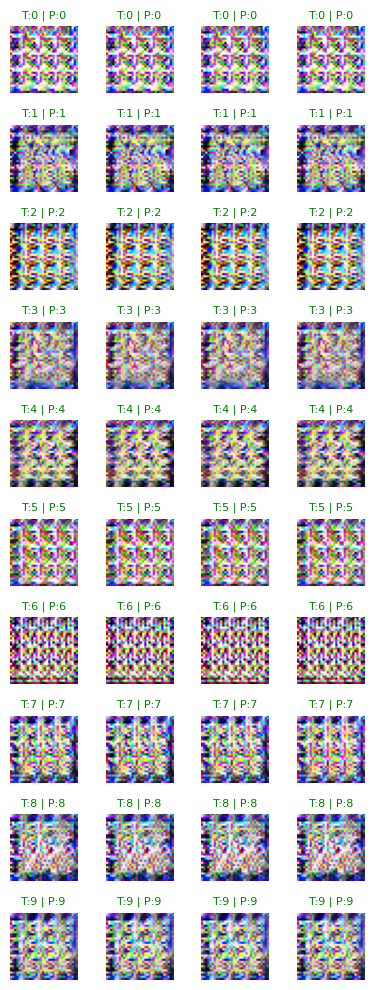

[GEN] Ep 41/100 | Loss 509.0215 | KL 1.0310 | CE 0.2061 | COS 0.2482 | ORT 0.1155 | SSIM 0.0009 | time 24.4s
[GEN] Ep 42/100 | Loss 508.1679 | KL 1.0260 | CE 0.2075 | COS 0.2478 | ORT 0.1153 | SSIM 0.0009 | time 24.2s
[GEN] Ep 43/100 | Loss 507.7620 | KL 1.0240 | CE 0.2089 | COS 0.2476 | ORT 0.1151 | SSIM 0.0009 | time 24.2s
[GEN] Ep 44/100 | Loss 506.4406 | KL 1.0214 | CE 0.2079 | COS 0.2469 | ORT 0.1149 | SSIM 0.0009 | time 24.1s
[GEN] Ep 45/100 | Loss 507.0262 | KL 1.0198 | CE 0.2093 | COS 0.2470 | ORT 0.1153 | SSIM 0.0009 | time 24.2s
[GEN] Ep 46/100 | Loss 505.9144 | KL 1.0188 | CE 0.2082 | COS 0.2466 | ORT 0.1149 | SSIM 0.0009 | time 24.1s
[GEN] Ep 47/100 | Loss 506.6445 | KL 1.0217 | CE 0.2112 | COS 0.2467 | ORT 0.1146 | SSIM 0.0009 | time 24.2s
[GEN] Ep 48/100 | Loss 504.7580 | KL 1.0169 | CE 0.2096 | COS 0.2460 | ORT 0.1142 | SSIM 0.0009 | time 24.3s
[GEN] Ep 49/100 | Loss 503.8085 | KL 1.0177 | CE 0.2093 | COS 0.2453 | ORT 0.1140 | SSIM 0.0009 | time 24.1s
[GEN] Ep 50/100 | L

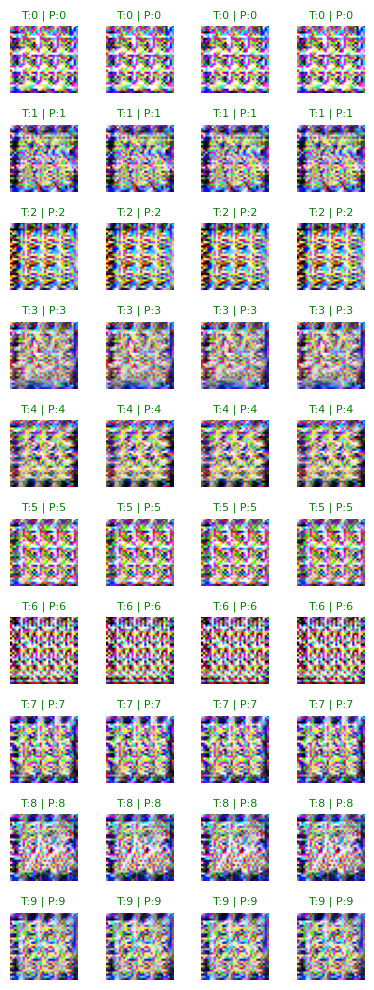

[GEN] Ep 51/100 | Loss 502.9109 | KL 1.0126 | CE 0.2103 | COS 0.2448 | ORT 0.1139 | SSIM 0.0009 | time 24.2s
[GEN] Ep 52/100 | Loss 502.1993 | KL 1.0142 | CE 0.2113 | COS 0.2441 | ORT 0.1135 | SSIM 0.0009 | time 24.2s
[GEN] Ep 53/100 | Loss 502.9353 | KL 1.0127 | CE 0.2119 | COS 0.2446 | ORT 0.1138 | SSIM 0.0009 | time 24.2s
[GEN] Ep 54/100 | Loss 503.5236 | KL 1.0099 | CE 0.2104 | COS 0.2451 | ORT 0.1145 | SSIM 0.0009 | time 24.2s
[GEN] Ep 55/100 | Loss 500.1907 | KL 1.0115 | CE 0.2112 | COS 0.2432 | ORT 0.1127 | SSIM 0.0009 | time 24.4s
[GEN] Ep 56/100 | Loss 499.9210 | KL 1.0069 | CE 0.2107 | COS 0.2432 | ORT 0.1130 | SSIM 0.0009 | time 24.2s
[GEN] Ep 57/100 | Loss 499.5082 | KL 1.0074 | CE 0.2102 | COS 0.2429 | ORT 0.1129 | SSIM 0.0009 | time 24.2s
[GEN] Ep 58/100 | Loss 498.6583 | KL 1.0077 | CE 0.2112 | COS 0.2424 | ORT 0.1123 | SSIM 0.0009 | time 24.2s
[GEN] Ep 59/100 | Loss 499.3950 | KL 1.0098 | CE 0.2112 | COS 0.2428 | ORT 0.1125 | SSIM 0.0009 | time 24.2s
[GEN] Ep 60/100 | L

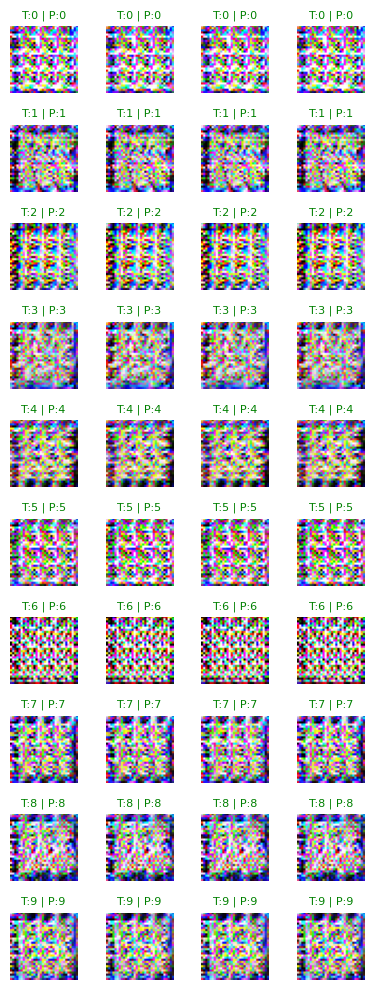

[GEN] Ep 61/100 | Loss 498.7635 | KL 1.0052 | CE 0.2121 | COS 0.2426 | ORT 0.1123 | SSIM 0.0009 | time 24.3s
[GEN] Ep 62/100 | Loss 498.2491 | KL 1.0045 | CE 0.2119 | COS 0.2422 | ORT 0.1123 | SSIM 0.0009 | time 24.5s
[GEN] Ep 63/100 | Loss 497.7118 | KL 1.0075 | CE 0.2117 | COS 0.2417 | ORT 0.1120 | SSIM 0.0009 | time 24.3s
[GEN] Ep 64/100 | Loss 497.1603 | KL 1.0038 | CE 0.2133 | COS 0.2415 | ORT 0.1117 | SSIM 0.0009 | time 24.3s
[GEN] Ep 65/100 | Loss 498.0592 | KL 1.0007 | CE 0.2129 | COS 0.2419 | ORT 0.1126 | SSIM 0.0009 | time 24.3s
[GEN] Ep 66/100 | Loss 496.8840 | KL 1.0016 | CE 0.2136 | COS 0.2414 | ORT 0.1117 | SSIM 0.0009 | time 24.1s
[GEN] Ep 67/100 | Loss 496.6677 | KL 1.0014 | CE 0.2138 | COS 0.2413 | ORT 0.1115 | SSIM 0.0009 | time 24.1s
[GEN] Ep 68/100 | Loss 496.3910 | KL 1.0034 | CE 0.2135 | COS 0.2412 | ORT 0.1113 | SSIM 0.0009 | time 24.1s
[GEN] Ep 69/100 | Loss 495.6493 | KL 1.0042 | CE 0.2130 | COS 0.2407 | ORT 0.1110 | SSIM 0.0009 | time 24.2s
[GEN] Ep 70/100 | L

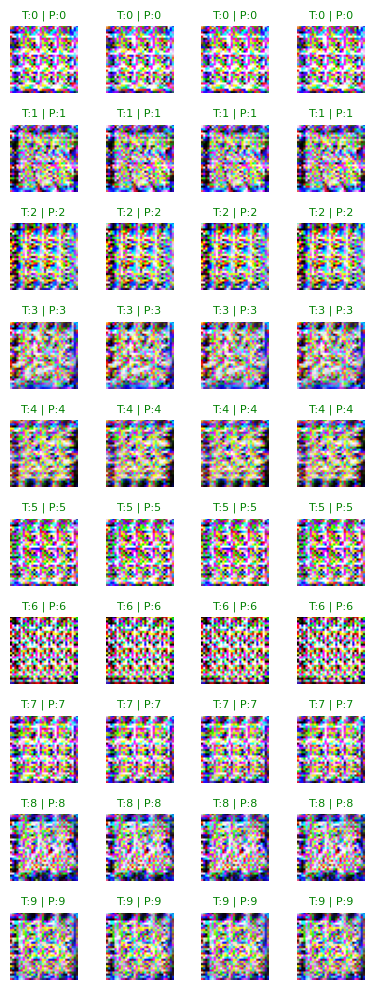

[GEN] Ep 71/100 | Loss 493.3520 | KL 1.0022 | CE 0.2133 | COS 0.2400 | ORT 0.1096 | SSIM 0.0009 | time 24.1s
[GEN] Ep 72/100 | Loss 494.3162 | KL 0.9994 | CE 0.2126 | COS 0.2402 | ORT 0.1107 | SSIM 0.0009 | time 24.3s
[GEN] Ep 73/100 | Loss 494.4299 | KL 1.0047 | CE 0.2134 | COS 0.2401 | ORT 0.1103 | SSIM 0.0009 | time 24.2s
[GEN] Ep 74/100 | Loss 494.4522 | KL 1.0058 | CE 0.2123 | COS 0.2400 | ORT 0.1105 | SSIM 0.0009 | time 24.2s
[GEN] Ep 75/100 | Loss 493.0382 | KL 1.0021 | CE 0.2128 | COS 0.2396 | ORT 0.1097 | SSIM 0.0009 | time 24.1s
[GEN] Ep 76/100 | Loss 492.8309 | KL 1.0003 | CE 0.2137 | COS 0.2395 | ORT 0.1096 | SSIM 0.0009 | time 24.3s
[GEN] Ep 77/100 | Loss 492.8475 | KL 0.9974 | CE 0.2131 | COS 0.2395 | ORT 0.1101 | SSIM 0.0009 | time 24.2s
[GEN] Ep 78/100 | Loss 492.5079 | KL 1.0018 | CE 0.2140 | COS 0.2391 | ORT 0.1096 | SSIM 0.0009 | time 24.1s
[GEN] Ep 79/100 | Loss 492.3901 | KL 1.0016 | CE 0.2131 | COS 0.2390 | ORT 0.1097 | SSIM 0.0009 | time 24.0s
[GEN] Ep 80/100 | L

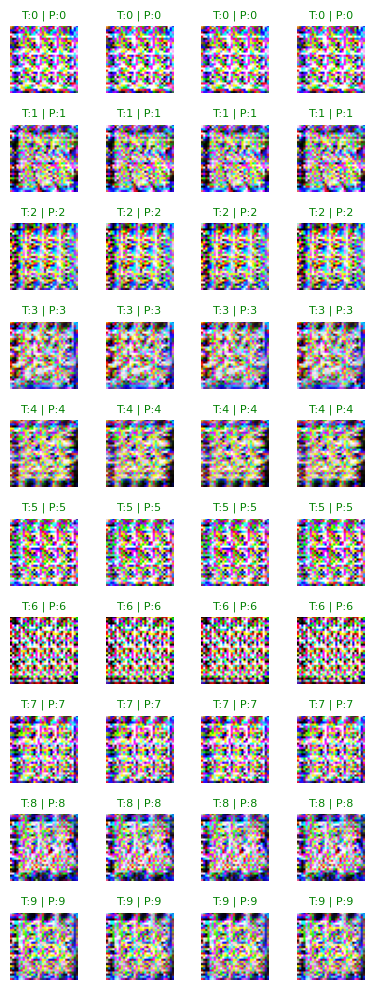

[GEN] Ep 81/100 | Loss 489.9675 | KL 0.9976 | CE 0.2145 | COS 0.2379 | ORT 0.1085 | SSIM 0.0009 | time 24.1s
[GEN] Ep 82/100 | Loss 491.1547 | KL 0.9978 | CE 0.2136 | COS 0.2387 | ORT 0.1091 | SSIM 0.0009 | time 24.1s
[GEN] Ep 83/100 | Loss 491.5845 | KL 0.9990 | CE 0.2144 | COS 0.2386 | ORT 0.1093 | SSIM 0.0009 | time 24.3s
[GEN] Ep 84/100 | Loss 490.5585 | KL 0.9984 | CE 0.2139 | COS 0.2383 | ORT 0.1087 | SSIM 0.0009 | time 24.2s
[GEN] Ep 85/100 | Loss 490.9908 | KL 0.9971 | CE 0.2135 | COS 0.2384 | ORT 0.1093 | SSIM 0.0009 | time 24.2s
[GEN] Ep 86/100 | Loss 490.0461 | KL 0.9984 | CE 0.2125 | COS 0.2379 | ORT 0.1089 | SSIM 0.0009 | time 24.1s
[GEN] Ep 87/100 | Loss 489.8168 | KL 0.9968 | CE 0.2146 | COS 0.2378 | ORT 0.1085 | SSIM 0.0009 | time 24.2s
[GEN] Ep 88/100 | Loss 489.5458 | KL 0.9953 | CE 0.2134 | COS 0.2379 | ORT 0.1086 | SSIM 0.0009 | time 24.1s
[GEN] Ep 89/100 | Loss 489.3895 | KL 0.9995 | CE 0.2155 | COS 0.2372 | ORT 0.1082 | SSIM 0.0009 | time 24.1s
[GEN] Ep 90/100 | L

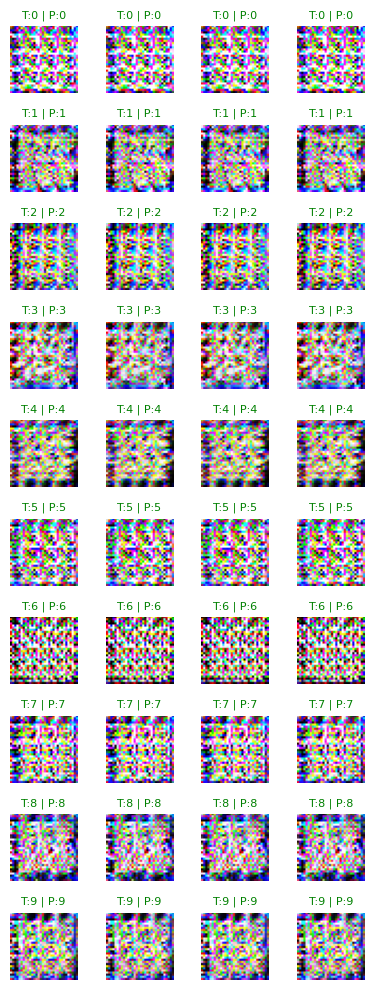

[GEN] Ep 91/100 | Loss 489.3449 | KL 0.9955 | CE 0.2126 | COS 0.2376 | ORT 0.1088 | SSIM 0.0009 | time 24.1s
[GEN] Ep 92/100 | Loss 488.1140 | KL 0.9939 | CE 0.2150 | COS 0.2369 | ORT 0.1080 | SSIM 0.0009 | time 24.2s
[GEN] Ep 93/100 | Loss 488.0594 | KL 0.9963 | CE 0.2142 | COS 0.2368 | ORT 0.1079 | SSIM 0.0009 | time 24.2s
[GEN] Ep 94/100 | Loss 487.8260 | KL 0.9942 | CE 0.2141 | COS 0.2368 | ORT 0.1079 | SSIM 0.0009 | time 24.1s
[GEN] Ep 95/100 | Loss 489.3621 | KL 0.9898 | CE 0.2148 | COS 0.2375 | ORT 0.1090 | SSIM 0.0009 | time 24.1s
[GEN] Ep 96/100 | Loss 488.1947 | KL 0.9937 | CE 0.2149 | COS 0.2368 | ORT 0.1081 | SSIM 0.0009 | time 24.2s
[GEN] Ep 97/100 | Loss 486.9778 | KL 0.9937 | CE 0.2142 | COS 0.2362 | ORT 0.1076 | SSIM 0.0009 | time 24.3s
[GEN] Ep 98/100 | Loss 486.3578 | KL 0.9927 | CE 0.2144 | COS 0.2360 | ORT 0.1073 | SSIM 0.0009 | time 24.2s
[GEN] Ep 99/100 | Loss 487.1766 | KL 0.9926 | CE 0.2153 | COS 0.2365 | ORT 0.1074 | SSIM 0.0009 | time 24.1s
[GEN] Ep 100/100 | 

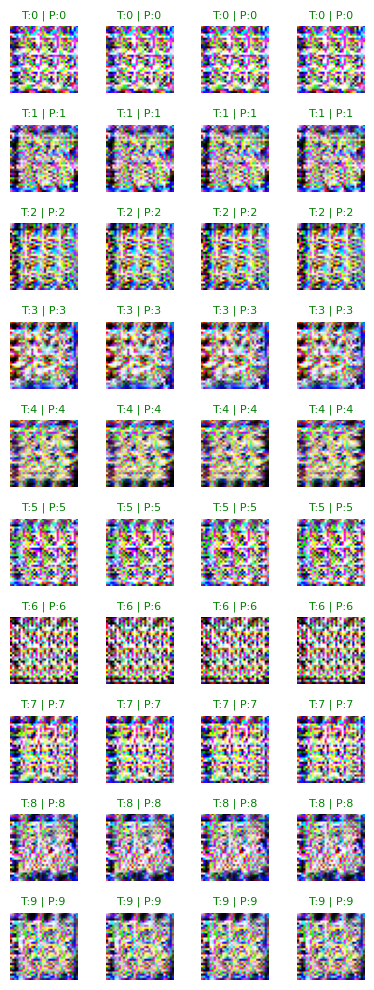

In [20]:
print("Starting generator training...")
train_generator(epochs=100, batch_size=64)



Running t-SNE evaluation...
[t-SNE] Inversion Accuracy: 68.00%


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


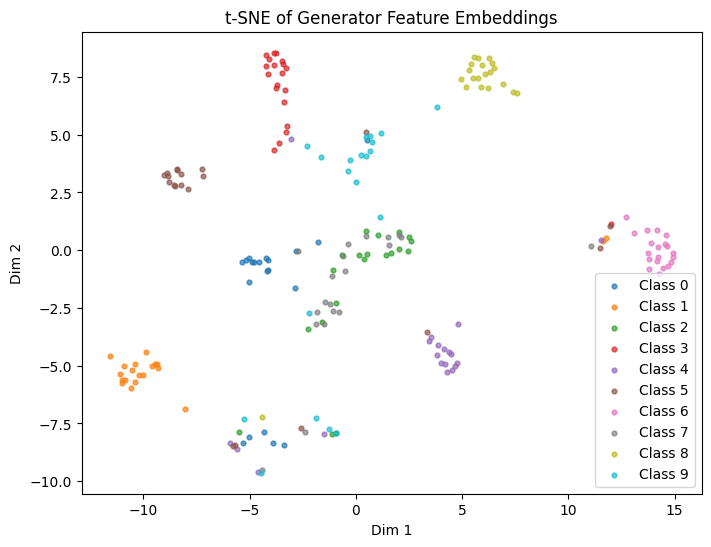

In [21]:
# Final t-SNE visualization
print("Running t-SNE evaluation...")
eval_tsne_grid(gen, classifier, samples_per_class=SAMPLES_PER_CLASS)

Generating final image grid...


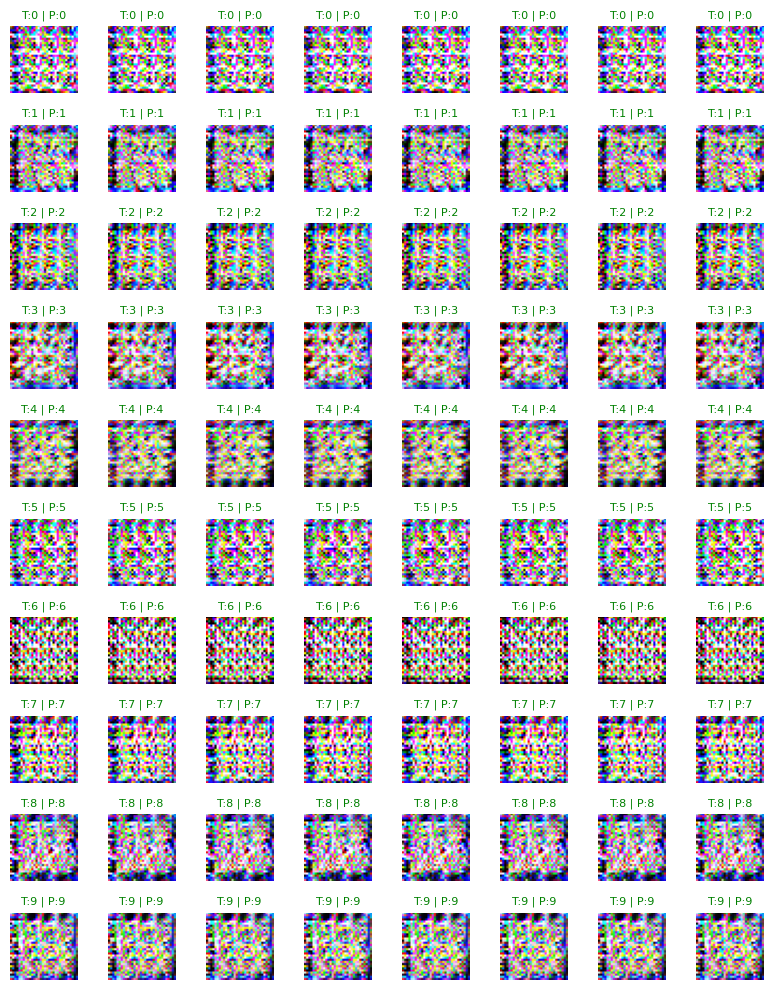

In [22]:
# Final grid of generated images
print("Generating final image grid...")
show_generated_images(gen, classifier, samples_per_class=8)

In [23]:
final_acc = inversion_accuracy(gen, classifier, n_per_class=100)
print(f"FINAL INVERSION ACCURACY: {final_acc:.2f}%")

FINAL INVERSION ACCURACY: 100.00%
